In [11]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


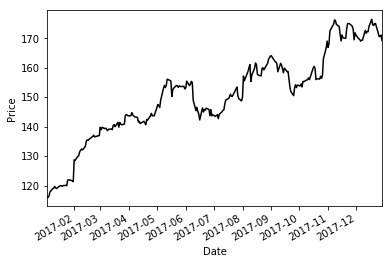

In [2]:
# Importing the necessary tools
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime 

# The Date of the data can be changed to get yearly data
stock_data = pdr.get_data_yahoo('AAPL', 
                          start=datetime.datetime(2017, 1, 1), 
                          end=datetime.datetime(2017, 12, 31))

# Initialising the plot figure
fig = plt.figure()
ax1 = fig.add_subplot(111,  ylabel='Price')

# Plotting the closing price
stock_data['Close'].plot(ax=ax1, color='k')
plt.show()

In [3]:
# Setting time periods for long and short moving averages
short_term = 5
long_term = 10

# Initialising the `signal` DataFrame for indicators
signal = pd.DataFrame(index=stock_data.index)
signal['indicator_SMA'] = 0.0 
signal['indicator_EMA'] = 0.0

# Creating Short Simple Moving Average 
signal['short_SMA'] = stock_data['Close'].rolling(window=short_term, min_periods=1, center=False).mean()

# Creating Long Simple Moving Average 
signal['long_SMA'] = stock_data['Close'].rolling(window=long_term, min_periods=1, center=False).mean()

# Short Exponential Moving Average
signal['short_EMA'] = stock_data['Close'].ewm(span=short_term,adjust=False).mean()

# Long Exponential Moving Average
signal['long_EMA'] = stock_data['Close'].ewm(span=long_term,adjust=False).mean()

# Creating signals
signal['indicator_SMA'][short_term:] = np.where(signal['short_SMA'][short_term:] 
                                            > signal['long_SMA'][short_term:], 1.0, 0.0)   

signal['indicator_EMA'][short_term:] = np.where(signal['short_EMA'][short_term:] 
                                            > signal['long_EMA'][short_term:], 1.0, 0.0) 
# Generating the trading orders
signal['orders_SMA'] = signal['indicator_SMA'].diff()
signal['orders_EMA'] = signal['indicator_EMA'].diff()

# Print Indicators
print(signal)

            indicator_SMA  indicator_EMA   short_SMA    long_SMA   short_EMA  \
Date                                                                           
2017-01-03            0.0            0.0  116.150002  116.150002  116.150002   
2017-01-04            0.0            0.0  116.084999  116.084999  116.106667   
2017-01-05            0.0            0.0  116.260000  116.260000  116.274445   
2017-01-06            0.0            0.0  116.672501  116.672501  116.819631   
2017-01-09            0.0            0.0  117.136000  117.136000  117.543087   
2017-01-10            1.0            1.0  117.728000  117.465000  118.065391   
2017-01-11            1.0            1.0  118.474001  117.791429  118.626928   
2017-01-12            1.0            1.0  119.002000  117.973750  118.834618   
2017-01-13            1.0            1.0  119.228000  118.092222  118.903079   
2017-01-17            1.0            1.0  119.430000  118.283000  119.268719   
2017-01-18            1.0            1.0

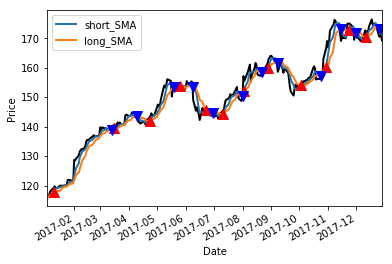

In [4]:
# Initialising the plot figure
fig_SMA = plt.figure()
ax1 = fig_SMA.add_subplot(111,  ylabel='Price')

# Plotting the closing price
stock_data['Close'].plot(ax=ax1, color='k', lw=2.)

# Plotting the short and long simple moving averages
signal[['short_SMA', 'long_SMA']].plot(ax=ax1, lw=2.)

# Plotting the buy signals
ax1.plot(signal.loc[signal.orders_SMA == 1.0].index, 
         signal.short_SMA[signal.orders_SMA == 1.0],
         '^', markersize=10, color='r')
       
# Plotting the sell signals
ax1.plot(signal.loc[signal.orders_SMA == -1.0].index, 
           signal.short_SMA[signal.orders_SMA == -1.0],
          'v', markersize=10, color='b')
         
# Show the plot
plt.show()

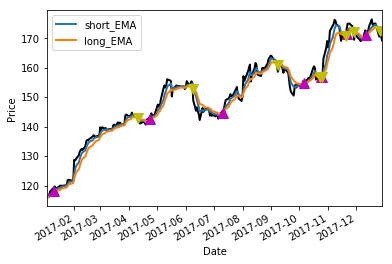

In [5]:
# Initialising the plot figure
fig_EMA = plt.figure()
ax1 = fig_EMA.add_subplot(111,  ylabel='Price')

# Plotting the closing price
stock_data['Close'].plot(ax=ax1, color='k', lw=2.)

# Plotting the short and long exponential moving averages
signal[['short_EMA', 'long_EMA']].plot(ax=ax1, lw=2.)

# Plotting the buy signals
ax1.plot(signal.loc[signal.orders_EMA == 1.0].index, 
        signal.short_EMA[signal.orders_EMA == 1.0],
         '^', markersize=10, color='m')
         
# Plotting the sell signals
ax1.plot(signal.loc[signal.orders_EMA == -1.0].index, 
         signal.short_EMA[signal.orders_EMA == -1.0],
         'v', markersize=10, color='y')
         
# Show the plot
plt.show()

In [6]:
# Setting the initial capital
initial_capital_S= float(10000.0)
initial_capital_E= float(10000.0)

# Creating two DataFrames 'orders_S' and 'orders_E'
orders_S = pd.DataFrame(index=signal.index).fillna(0.0)
orders_E = pd.DataFrame(index=signal.index).fillna(0.0)

# Buying 100 shares
orders_S['AAPL'] = 100*signal['indicator_SMA']   
orders_E['AAPL'] = 100*signal['indicator_EMA']

# Initialising the portfolios   
portfolio_S = orders_S.multiply(stock_data['Adj Close'], axis=0)
portfolio_E = orders_E.multiply(stock_data['Adj Close'], axis=0)

# The difference in shares owned 
pos_diff_S = orders_S.diff()
pos_diff_E = orders_E.diff()

# Adding 'Holdings' to portfolios
portfolio_S['holdings'] = (orders_S.multiply(stock_data['Adj Close'], axis=0)).sum(axis=1)
portfolio_E['holdings'] = (orders_E.multiply(stock_data['Adj Close'], axis=0)).sum(axis=1)

# Adding 'cash' to portfolios
portfolio_S['cash'] = initial_capital_S - (pos_diff_S.multiply(stock_data['Adj Close'], axis=0)).sum(axis=1).cumsum() 
portfolio_E['cash'] = initial_capital_E - (pos_diff_E.multiply(stock_data['Adj Close'], axis=0)).sum(axis=1).cumsum()

# Adding 'total' to portfolios
portfolio_S['total'] = portfolio_S['cash'] + portfolio_S['holdings']
portfolio_E['total'] = portfolio_E['cash'] + portfolio_E['holdings']

# Adding 'returns' to portfolios
portfolio_S['returns'] = portfolio_S['total'].pct_change(1)
portfolio_E['returns'] = portfolio_E['total'].pct_change(1)

# Creating signals
signal['orders_SMA'] = signal['indicator_SMA'].diff()
signal['orders_EMA'] = signal['indicator_EMA'].diff()

Date
2017-01-03    10000.000000
2017-01-04    10000.000000
2017-01-05    10000.000000
2017-01-06    10000.000000
2017-01-09    10000.000000
2017-01-10    10000.000000
2017-01-11    10061.322784
2017-01-12    10013.414764
2017-01-13     9993.293762
2017-01-17    10085.274506
2017-01-18    10084.317780
2017-01-19    10064.196014
2017-01-20    10085.274506
2017-01-23    10092.939758
2017-01-24    10082.401276
2017-01-25    10265.403748
2017-01-26    10271.151733
2017-01-27    10272.110748
2017-01-30    10241.451263
2017-01-31    10214.620972
2017-02-01    10923.639679
2017-02-02    10902.561951
2017-02-03    10955.258942
2017-02-06    11071.192932
2017-02-07    11189.999390
2017-02-08    11238.864136
2017-02-09    11330.281067
2017-02-10    11301.412964
2017-02-13    11414.001465
2017-02-14    11580.476379
                  ...     
2017-11-16    13673.388672
2017-11-17    13673.388672
2017-11-20    13673.388672
2017-11-21    13673.388672
2017-11-22    13673.388672
2017-11-24    13673.388

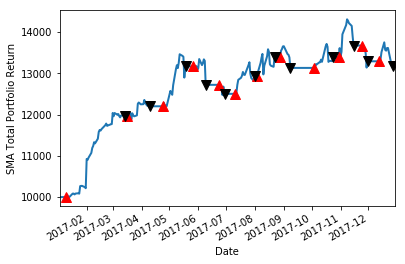

In [11]:
# Initialising the plot figure
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, ylabel='SMA Total Portfolio Return')

# Plotting the equity curve
portfolio_S['total'].plot(ax=ax2, lw=2.)

# Plotting the buy signals
ax2.plot(portfolio_S.loc[signal.orders_SMA == 1.0].index, 
         portfolio_S.total[signal.orders_SMA == 1.0],
         '^', markersize=10, color='r')

# Plotting the sell signals
ax2.plot(portfolio_S.loc[signal.orders_SMA == -1.0].index, 
         portfolio_S.total[signal.orders_SMA == -1.0],
         'v', markersize=10, color='k')

# Printing total portfolio returns

portfolio_S['total']

Date
2017-01-03    10000.000000
2017-01-04    10000.000000
2017-01-05    10000.000000
2017-01-06    10000.000000
2017-01-09    10000.000000
2017-01-10    10000.000000
2017-01-11    10061.322784
2017-01-12    10013.414764
2017-01-13     9993.293762
2017-01-17    10085.274506
2017-01-18    10084.317780
2017-01-19    10064.196014
2017-01-20    10085.274506
2017-01-23    10092.939758
2017-01-24    10082.401276
2017-01-25    10265.403748
2017-01-26    10271.151733
2017-01-27    10272.110748
2017-01-30    10241.451263
2017-01-31    10214.620972
2017-02-01    10923.639679
2017-02-02    10902.561951
2017-02-03    10955.258942
2017-02-06    11071.192932
2017-02-07    11189.999390
2017-02-08    11238.864136
2017-02-09    11330.281067
2017-02-10    11301.412964
2017-02-13    11414.001465
2017-02-14    11580.476379
                  ...     
2017-11-16    15520.700073
2017-11-17    15428.211975
2017-11-20    15411.663818
2017-11-21    15411.663818
2017-11-22    15588.850403
2017-11-24    15589.823

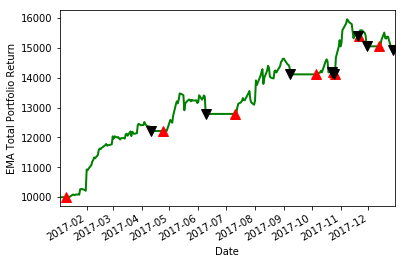

In [10]:
# Initialising the plot figure
fig3 = plt.figure()
ax3 = fig3.add_subplot(111, ylabel='EMA Total Portfolio Return')

# Plotting the equity curve
portfolio_E['total'].plot(ax=ax3,color='g', lw=2.)

# Plotting the buy signals
ax3.plot(portfolio_E.loc[signal.orders_EMA == 1.0].index, 
         portfolio_E.total[signal.orders_EMA == 1.0],
         '^', markersize=10, color='r')

# Plotting the sell signals
ax3.plot(portfolio_E.loc[signal.orders_EMA == -1.0].index, 
         portfolio_E.total[signal.orders_EMA == -1.0],
         'v', markersize=10, color='k')

# Printing total portfolio returns
portfolio_E['total']